In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from copy import deepcopy
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

base_path = '/Users/freezylex/Documents/course_work/'

## Idea

- Get slope, level and curvature from the term structure. 
- Use PCA method

In [2]:
curve = pd.read_csv(os.path.join(base_path, 'data/metrics/for_PCA.csv'), 
                    index_col = 'Date', parse_dates = True)
curve *= 10000
curve_train, curve_test = curve.loc['2015-06-01': '2016-01-29'], curve.loc['2016-02':]

In [3]:
curve.head(1)

,0.08333333333333333,0.16666666666666666,0.25,0.5,0.75,1.0,1.5,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,15.0,20.0
Date,,,,,,,,,,,,,,,,,,
2015-03-02,1346.136834,1350.072805,1354.181212,1367.049552,1379.623655,1391.300462,1412.240215,1429.261274,1452.107791,1461.789118,1457.950916,1441.162335,1412.974678,1377.398657,1339.436882,1303.027261,1171.593108,1093.910804


In [4]:
curve.shape

(245, 18)

In [5]:
pca = PCA(n_components=3)
pca.fit(curve_train)

PCA(n_components=3)

In [6]:
pca.explained_variance_ratio_.sum() #Explained variance

0.988006407153106

In [7]:
names = ['level', 'slope', 'curvature']
pd.DataFrame(pca.explained_variance_ratio_, index = names, columns = ['Variance Explained by component'])

,Variance Explained by component
level,0.774673
slope,0.166120
curvature,0.047214


In [8]:
curve_desc_train = pd.DataFrame(pca.transform(curve_train), 
             columns = names,
             index = curve_train.index)

curve_desc_test = pd.DataFrame(pca.transform(curve_test), 
             columns = names,
             index = curve_test.index)

In [9]:
all_comp = pd.concat([curve_desc_train, curve_desc_test])

In [10]:
np.corrcoef((curve_train['0.25'] + curve_train['2.0'] + curve_train['10.0'])/3, 
            curve_desc_train['level'].values) #1st component - level

array([[1.        , 0.98654435],
       [0.98654435, 1.        ]])

In [11]:
pearsonr((curve_train['0.25'] + curve_train['2.0'] + curve_train['10.0'])/3,
         curve_desc_train['level'].values)

(0.9865443490352566, 2.821585406227452e-133)

In [12]:
np.corrcoef(curve_train['0.16666666666666666'].values - curve_train['10.0'].values, 
            curve_desc_train['slope'].values) #2nd component - slope

array([[1.        , 0.92732299],
       [0.92732299, 1.        ]])

In [13]:
np.corrcoef((- curve_train['10.0'].values - curve_train['1.0'].values + 2*curve_train['5.0'].values), 
            curve_desc_train['curvature'].values) #3nd component - curvature

array([[1.        , 0.51180016],
       [0.51180016, 1.        ]])

In [14]:

pearsonr((- curve_train['10.0'].values - curve_train['1.0'].values + 2*curve_train['5.0'].values),
        curve_desc_train['curvature'].values)

(0.5118001579440821, 1.146965371164799e-12)

In [11]:
all_comp.to_csv(os.path.join(base_path, 'data/metrics_final/PCA_curve.csv'))

In [17]:
all_comp.diff().corr()

,level,slope,curvature
level,1.000000,0.295572,-0.653123
slope,0.295572,1.000000,-0.735685
curvature,-0.653123,-0.735685,1.000000


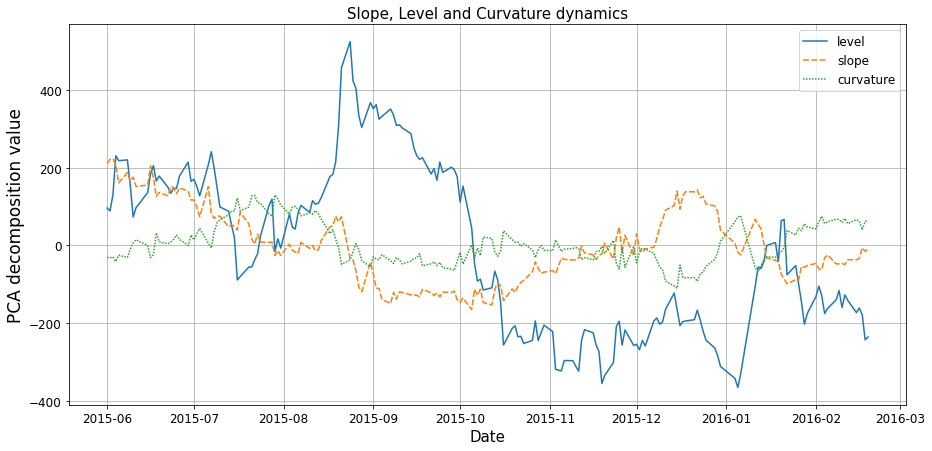

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data = all_comp)
plt.title('Slope, Level and Curvature dynamics', fontsize=15)
plt.ylabel('PCA decomposition value', fontsize=17)
plt.xlabel('Date', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12, title_fontsize=15)
plt.grid()
plt.savefig(os.path.join(base_path, 'graphs/PCA_vars.png'), dpi=300)